# Open-Loop Simulation

In [84]:
import numpy as np
from control import acker
from DCmotor import dc_motor

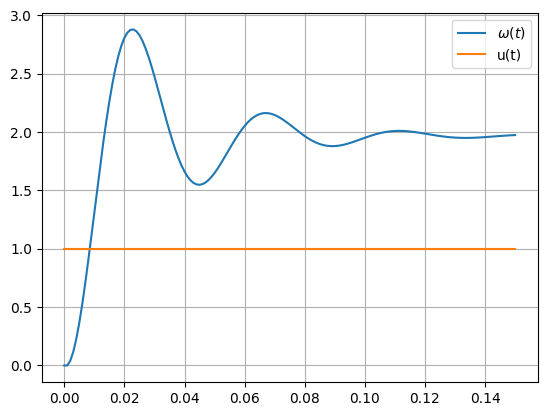

In [85]:
servo = dc_motor(0.5, 5.2e-4, 23.8e-3, 0.002, 2, 0.5)
servo.step(0.15)
servo.plot()

# Control synthesis

The state feedback $u=r-Kx$ can place the eigenvalues of (A - Bk) in any desired position. The following code computes the gain matrix $K$ such that the eigenvalues of (A - Bk) are placed in the desired position.

T_load:  0 DC error:  0.00999916455170835


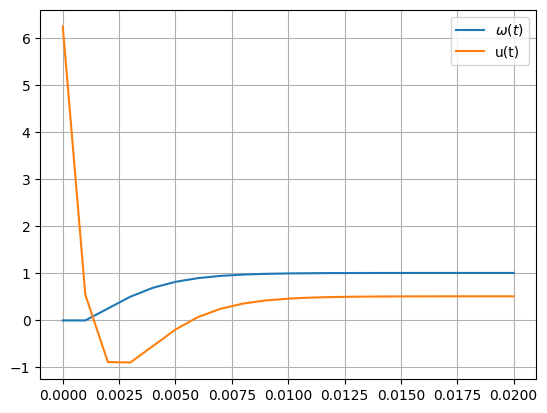

T_load:  100 DC error:  0.40845653765727086


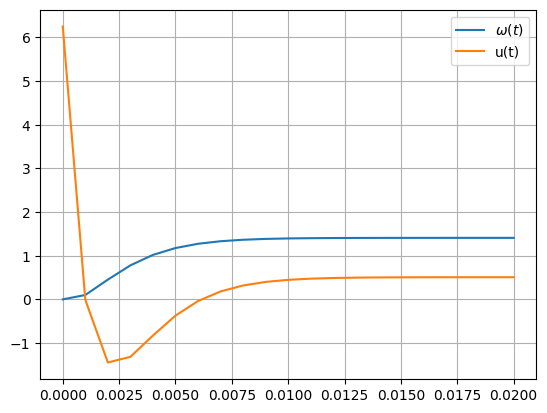

In [86]:
wd = 0.5/servo.sampling_time
K = acker(servo.A, servo.B, [-wd, -wd])
r = 1

def sim_static_gain(time, T_load):
    servo.sys_init()
    for i in range(int(time/servo.sampling_time)):
        x = np.array([[servo.simulation_data['Ia'][-1]], [servo.simulation_data['w'][-1]]])
        u = r/(1-0.84) - K.dot(x) # 1/0.84 is the static gain of the system to compensate DC Error
        servo.sys_dynamics(u[0][0], T_load)
    print('T_load: ', T_load, 'DC error: ', servo.simulation_data['w'][-1] - r)
    servo.plot()

sim_static_gain(0.02, 0)
sim_static_gain(0.02, 100)


## Internal Model
The eigenvalues of (A - Bk) are the poles of the closed-loop system, and they determine the transient response of the system. The closed-loop system is stable, but still has a DC error, this error can change due to change of load, environment, or aging. An integrative internal model will be added to the controller to eliminate the DC error.

The controller internal model loop can be defined by:
$$\dot{x}_c = A_c x_c + B_c r $$ 
$$u = K_c x_c - K x $$

The internal model of an integrator can be defined by:
$$A_c = 0$$
$$B_c = 1$$

T_load =  0 N.m DC error =  -5.02009545044757e-12


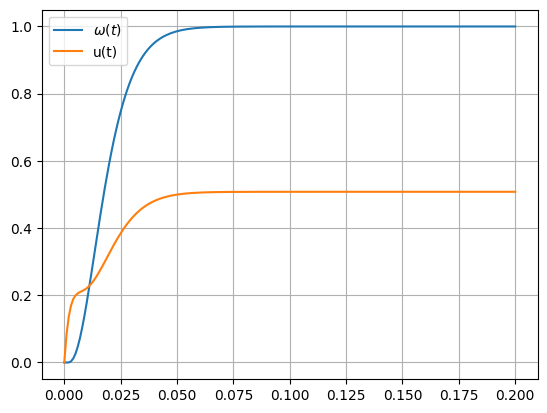

T_load =  100 N.m DC error =  1.4017675908917226e-12


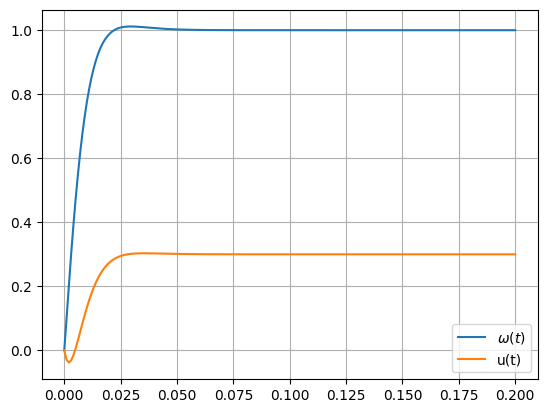

In [89]:
C = np.array([[0, 1]])
D = np.array([[0]])

Ac = [[0]]
Bc = 1
Aa = np.concatenate((servo.A, [[0],[0]]), axis=1) # Aa = [[A 0], -B_cC A_c]
Aa = np.concatenate((Aa, np.concatenate((C.dot(-Bc), Ac), axis=1)), axis=0)
Ba = np.concatenate((servo.B, D.dot(-Bc)), axis=0)

wd = 150
k = acker(Aa, Ba, [-wd, -wd, -wd])[0]
K = np.array([k[0:2]])
Kc = np.array([[k[2]]])

r = 1
def sim_internal_model(time, T_load):
    servo.sys_init()
    xc = 0
    for i in range(int(time/servo.sampling_time)):
        x = np.array([[servo.simulation_data['Ia'][-1]], [servo.simulation_data['w'][-1]]])
        u = Kc.dot(xc) - K.dot(x)
        servo.sys_dynamics(u[0][0], T_load)
        xc += Bc*(C.dot(x)[0][0] - r)*servo.sampling_time
    print('T_load = ', T_load, 'N.m', 'DC error = ', servo.simulation_data['w'][-1] - r)
    servo.plot()

sim_internal_model(0.2, 0)
sim_internal_model(0.2, 100)



## Add an observer to estimate the state and simulate with initial conditions

T_load =  0 N.m DC error =  -3.2385357418007743e-06


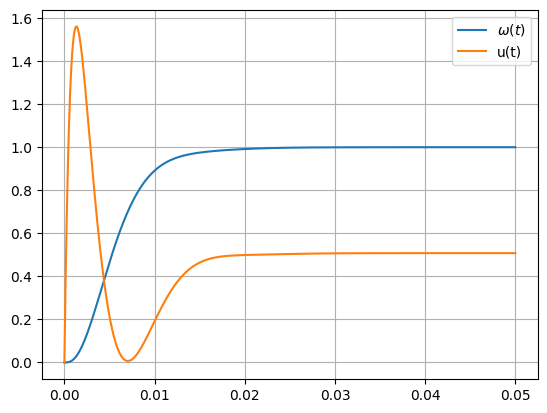

T_load =  100 N.m DC error =  -3.93606310045147e-06


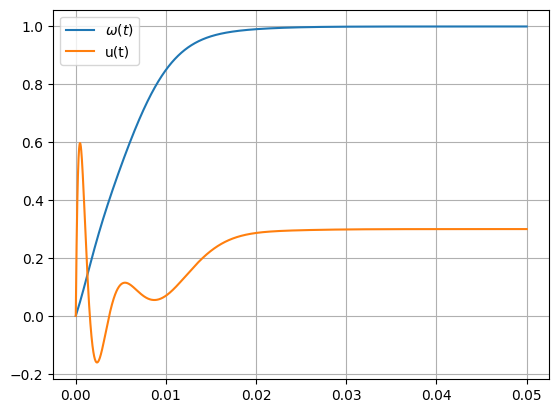

T_load =  100 N.m DC error =  -3.007679612365699e-06


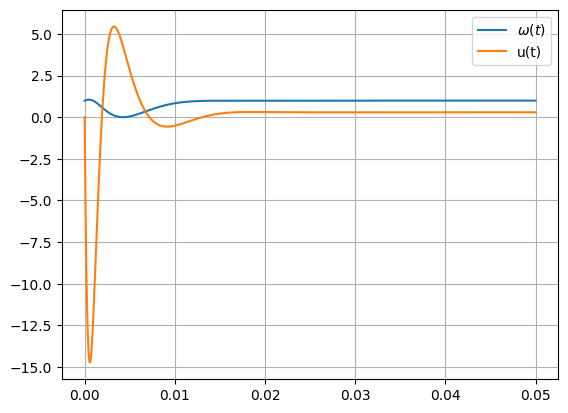

In [90]:
C = np.array([[0, 1]])
D = np.array([[0]])
Ac = [[0]]
Bc = 1
Aa = np.concatenate((servo.A, [[0],[0]]), axis=1) # Aa = [[A 0], -B_cC A_c]
Aa = np.concatenate((Aa, np.concatenate((C.dot(-Bc), Ac), axis=1)), axis=0)
Ba = np.concatenate((servo.B, D.dot(-Bc)), axis=0)

wd = 5e2
k = acker(Aa, Ba, [-wd, -wd, -wd])[0]
K = np.array([k[0:2]])
Kc = np.array([[k[2]]])

r = 1
def sim_internal_model_with_estimator(time, T_load, initialConditions={
        'Ia': 0,
        'w': 0
    }):
    servo.sys_init(sampling_time=1e-5, initialConditions=initialConditions)
    xc = 0
    x_obs = np.array([[0.], [0.]]) # observer state
    # Observer gain must be faster than the controller gain
    # Observer gain is calculated by the system model, not the augmented system
    L_obs = acker(servo.A.T, C.T, [-2*wd, -2*wd]).T # observer gain to compensate the uncertainly from the system model
    for i in range(int(time/servo.sampling_time)):
        u = Kc.dot(xc) - K.dot(x_obs)
        e = servo.simulation_data['w'][-1] - r # Erro
        dot_x_obs = (servo.A * 1.1 - L_obs.dot(C)).dot(x_obs) # 1.1 is estimator uncertainly simulation
        dot_x_obs += servo.B.dot(u) + L_obs.dot(servo.simulation_data['w'][-1])
        x_obs += dot_x_obs * servo.sampling_time
        servo.sys_dynamics(u[0][0], T_load)
        xc += Bc * e * servo.sampling_time

    print('T_load = ', T_load, 'N.m', 'DC error = ', servo.simulation_data['w'][-1] - r)
    servo.plot()

sim_internal_model_with_estimator(0.05, 0)
sim_internal_model_with_estimator(0.05, 100)
sim_internal_model_with_estimator(0.05, 100, initialConditions={
        'Ia': 0.1,
        'w': 1
})